In [11]:
# Install missing packages (runs only when package is not already available)
%pip install -q tensorflow matplotlib

# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Path setup
train_dir = '../datasets/train'
val_dir   = '../datasets/val'

print("Training images from:", train_dir)
print("Validation images from:", val_dir)


Training images from: ../datasets/train
Validation images from: ../datasets/val


In [13]:
# 3️⃣ Data preprocessing & augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
# 4️⃣ Load pretrained VGG16 (feature extractor)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()  


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 5️⃣ Freeze most convolutional layers, unfreeze last block (Block5)
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-8:]:   # roughly corresponds to Block5
    layer.trainable = True

print("Trainable layers after partial unfreezing:", sum([l.trainable for l in base_model.layers]))


Trainable layers after partial unfreezing: 8


In [16]:
# 6️⃣ Add custom classifier head
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # Binary classification
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [17]:
# 7️⃣ Train model
history = model.fit(
    train_generator,
    epochs=10,              
    validation_data=val_generator
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 421s 664ms/step - accuracy: 0.8975 - loss: 0.2324 - val_accuracy: 0.9738 - val_loss: 0.0722
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 446s 712ms/step - accuracy: 0.9585 - loss: 0.1059 - val_accuracy: 0.9764 - val_loss: 0.0609
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 514s 821ms/step - accuracy: 0.9687 - loss: 0.0803 - val_accuracy: 0.9792 - val_loss: 0.0594
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 570s 910ms/step - accuracy: 0.9737 - loss: 0.0677 - val_accuracy: 0.9818 - val_loss: 0.0498
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 625s 999ms/step - accuracy: 0.9767 - loss: 0.0609 - val_accuracy: 0.9822 - val_loss: 0.0458
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 557s 890ms/step - accuracy: 0.9822 - loss: 0.0472 - val_accuracy: 0.9846 - val_loss: 0.0466
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 556s 888ms/step - accuracy: 0.9835 - loss: 0.0435 - val_accuracy: 0.9826 - val_loss: 0.0491
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 504s 805ms/step - accuracy: 0.9856 -

In [18]:
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)


Train samples: 20000
Validation samples: 5000


In [19]:
model.save('best_model.keras')
print("✅ Model saved successfully!")



✅ Model saved successfully!


✅ Model saved to ../models/vgg16_catdog.h5


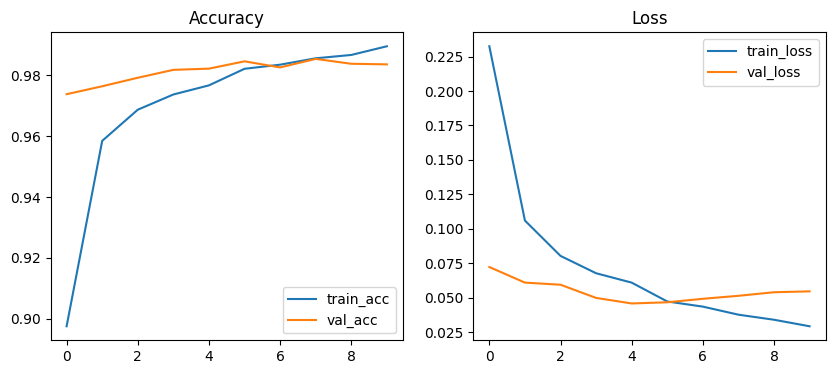

In [20]:
# ========================
# 8️⃣ Save model & plot training curves
# ========================
os.makedirs('../models', exist_ok=True)
model.save('../models/vgg16_catdog.h5')
print("✅ Model saved to ../models/vgg16_catdog.h5")


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import pandas as pd
import numpy as np
import os

# 1️⃣ Load test image paths (sorted by filename)
test_dir = '../datasets/test'
test_paths = sorted(glob(os.path.join(test_dir, '*.jpg')))  # change to '*.png' if needed

# 2️⃣ Create a DataFrame
test_df = pd.DataFrame({'filename': test_paths})

# 3️⃣ Build the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col=None,             # no labels for test set
    target_size=(224, 224),
    class_mode=None,
    shuffle=False
)

# 4️⃣ Generate predictions
predictions = model.predict(test_generator, verbose=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# 5️⃣ Create submission DataFrame (id starts from 1)
submission = pd.DataFrame({
    'id': range(1, len(predicted_labels) + 1),
    'label': predicted_labels
})

# 6️⃣ Save submission file
save_path = '../submission.csv'
submission.to_csv(save_path, index=False)
print(f"✅ submission.csv saved at: {os.path.abspath(save_path)}")
print(submission.head())


Found 500 validated image filenames.
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step
✅ submission.csv saved at: /Users/yuyue1/Desktop/IE4483VGG/submission.csv
   id  label
0   1      0
1   2      1
2   3      0
3   4      0
4   5      1
